<font size = "5"> **Chapter 1: [Introduction](CH1_00-Introduction.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Open DM3 Images, Spectra, Spectrum-Images and  Image-Stacks with pyNSID 

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Introduction/CH1_04-Open_File.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Introduction/CH1_04-Open_File.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

---
Reading a dm file and translating the data in a **[pyNSID](https://pycroscopy.github.io/pyNSID/)** style hf5py file to be compatible with  the **[pycroscopy](https://pycroscopy.github.io/pycroscopy/)** package.

Because, many other packages and programs for TEM data manipulation are based on the ``hdf5`` file-formats it is relatively easy to convert back and forward between them.



## Import packages for figures and
### Check Installed Packages

In [60]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


if test_package('pyTEMlib') < '0.2021.12.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade sidpy -q
    !{sys.executable} -m pip install  --upgrade SciFiReaders -q
    !{sys.executable} -m pip install  --upgrade pyNSID -q
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

installing pyTEMlib
done


### Load the plotting and figure packages

In [1]:
%pylab --no-import-all notebook
import sys
sys.path.insert(0, '../../pyTEMlib')
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library

import sidpy
import pyNSID
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__='CH1_04-Reading_File'
__notebook_version__='2021_12_14'

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.10.2


## Open a file 

This function opens a hfd5 file in the pyNSID style which enables you to keep track of your data anlysis.

Please see the **[Installation](CH1-Prerequisites.ipynb#TEM-Library)** notebook for installation.

We want to consolidate files into one dataset that belongs together.  For example a spectrum image dataset consists of: 
* Survey image, 
* EELS spectra 
* Z-contrast image acquired simultaneously with the spectra.


So load the top dataset first in the above example the survey image.

Please note that the plotting routine of ``matplotlib`` was introduced in **[Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)** notebook.

**Use the file p1-3hr.dm3 from TEM_data directory for a practice run**

In [2]:
# ------ Input ------- #
load_example = False
# -------------------- #

# Open file widget and select file which will be opened in code cell below
if not load_example:
    drive_directory = ft.get_last_path()
    file_widget = ft.FileWidget(drive_directory)

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

Cannot overwrite file. Using:  6_SiC-1.hf5


C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


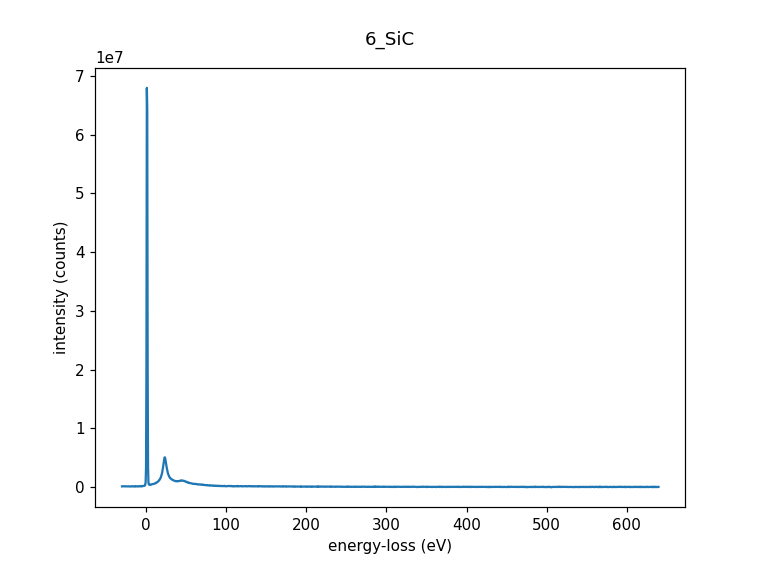

In [4]:
try:
    main_dataset.h5_dataset.file.close()
except:
    pass

if load_example:
    file_name = '../example_data/p1-3-hr3.dm3'
else:
    file_name = file_widget.file_name

main_dataset = ft.open_file(file_name)
current_channel = main_dataset.h5_dataset.parent.parent

main_dataset.plot()

## Data Structure

The data themselves reside in a ``sidpy dataset`` which we name ``current_dataset``.

The current_dataset has additional information stored as attributes which can be accessed through their name.

In [5]:
print(main_dataset)
main_dataset

sidpy.Dataset of type SPECTRUM with:
 dask.array<array, shape=(1340,), dtype=float32, chunksize=(1340,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (1340,)


sidpy.Dataset of type SPECTRUM with:
 dask.array<array, shape=(1340,), dtype=float32, chunksize=(1340,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (1340,)

In [6]:
print(f'size of current dataset is {main_dataset.shape}')

size of current dataset is (1340,)


The current_dataset has additional information stored as attributes which can be accessed through their name.

In [7]:
print('title: ', main_dataset.title)
print('data type: ', main_dataset.data_type)
main_dataset.metadata
for key in current_channel:
    try:
        if key in current_channel[key]:
            print(current_channel[key][key]['original_metadata'].attrs.keys())
    except:
        pass

title:  6_SiC
data type:  DataType.SPECTRUM


## File Structure
The current_channel (like a directory in a file system) contains several groups.

Below I show how to access one of those groups.

In [8]:
current_dataset = main_dataset
print(current_channel.keys())
def add_data(dataset, h5_group=None):
    """Write data to hdf5 file

    Parameters
    ----------
    dataset: sidpy.Dataset
        data to write to file
    h5_group: None, sidpy.Dataset, h5py.Group, h5py.Datset, h5py.File
        identifier to which group the data are added (if None the dataset must have a valid h5_dataset)

    Returns:
    log_group: h5py.Dataset
        reference the dataset has been written to. (is also stored in h5_dataset attribute of sipy.Dataset)
    """

    if h5_group is None:
        if isinstance(dataset.h5_dataset, h5py.Dataset):
            h5_group = dataset.h5_dataset.parent.parent.parent
    if isinstance(h5_group, h5py.Dataset):
        h5_group = h5_group.parent.parent.parent
    elif isinstance(h5_group, sidpy.Dataset):
        h5_group = h5_group.h5_dataset.parent.parent.parent
    elif isinstance(h5_group, h5py.File):
        h5_group = h5_group['Measurement_000']
        
    if not isinstance(h5_group, h5py.Group):
        raise TypeError('Need a valid indentifier for a hdf5 group to store data in')

    log_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Channel_')
    h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, log_group)
    
    if hasattr(dataset, 'meta_data'):
        if 'analysis' in dataset.meta_data:
            log_group['analysis'] = dataset.meta_data['analysis']
            
    dataset.h5_dataset = h5_dataset
    return h5_dataset

print(current_channel)
current_dataset.metadata= {'a': 'nix', 'b': 'gara'}
#new_data = pyNSID.hdf_io.write_results(current_channel.parent, dataset=current_dataset)
new_data = add_data(current_dataset, h5_group=None)

print(current_dataset.h5_dataset)
print(new_data)

<KeysViewHDF5 ['6_SiC', 'title']>
<HDF5 group "/Measurement_000/Channel_000" (2 members)>
<HDF5 dataset "6_SiC": shape (1340,), type "<f4">
<HDF5 dataset "6_SiC": shape (1340,), type "<f4">


C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [9]:
# print(dict(new_data['a1_ 410s']['metadata'].attrs))

An important attribute in ``current_dataset`` is the ``original_metadata`` group, where all the original metadata of your file reside in the ``attributes``. This is usually a long list for ``dm3`` files.

In [10]:
current_dataset.h5_dataset.parent['original_metadata'].keys()

<KeysViewHDF5 ['DM', 'DocumentObjectList', 'DocumentTags', 'Image Behavior', 'ImageList', 'ImageSourceList', 'MinVersionList', 'Page Behavior', 'SentinelList', 'Thumbnails']>

In [11]:
for key,value in current_dataset.h5_dataset.parent['original_metadata'].attrs.items():
    print(key, value)
print(current_dataset.h5_dataset)    

ApplicationBounds [   0    0 1511 2560]
HasWindowPosition 1
InImageMode 1
NextDocumentObjectID 9
WindowPosition [ 23 142 365 812]
<HDF5 dataset "6_SiC": shape (1340,), type "<f4">


In [12]:
print(current_channel.keys())

<KeysViewHDF5 ['6_SiC', 'title']>


## Adding Data

To add another dataset that belongs to this measurement we will use the **h5_add_channel** from  **filetools** in the  pyTEMlib package.

Here is how we add a channel there.

We can also add a new measurement group (add_measurement in pyTEMlib) for similar datasets.

This is equivalent to making a new directory in a file structure on your computer.

In [13]:
import pyNSID

def add_dataset(dataset, h5_group=None):
    """Write data to hdf5 file

    Parameters
    ----------
    dataset: sidpy.Dataset
        data to write to file
    h5_group: None, sidpy.Dataset, h5py.Group, h5py.Datset, h5py.File
        identifier to which group the data are added (if None the dataset must have a valid h5_dataset)

    Returns:
    log_group: h5py.Dataset
        reference the dataset has been written to. (is also stored in h5_dataset attribute of sipy.Dataset)
    """

    if h5_group is None:
        if isinstance(dataset.h5_dataset, h5py.Dataset):
            h5_group = dataset.h5_dataset.parent.parent.parent
    if isinstance(h5_group, h5py.Dataset):
        h5_group = h5_group.parent.parent.parent
    elif isinstance(h5_group, sidpy.Dataset):
        h5_group = h5_group.h5_dataset.parent.parent.parent
    elif isinstance(h5_group, h5py.File):
        h5_group = h5_group['Measurement_000']

    if not isinstance(h5_group, h5py.Group):
        raise TypeError('Need a valid indentifier for a hdf5 group to store data in')

    log_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Channel_')
    h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, log_group)

    if hasattr(dataset, 'meta_data'):
        if 'analysis' in dataset.meta_data:
            log_group['analysis'] = dataset.meta_data['analysis']

    dataset.h5_dataset = h5_dataset
    return h5_dataset


We use above functions to add the content of a (random) data-file to the current file.

This is important if you for example want to add a Z-contrast or survey-image to an spectrum image.

Therefore, these functions enable you to collect the data from different files that belong together.


In [14]:
#new_channel = h5_add_channel(current_channel)
add_dataset(current_dataset, current_channel.parent)

ft.h5_tree(current_channel)  #wraps usid.hdf_utils.print_tree(h5_file)

/Measurement_000/Channel_000
├ 6_SiC
  -----
  ├ 6_SiC
  ├ energy_loss
  ├ original_metadata
    -----------------
    ├ DM
      --
    ├ DocumentObjectList
      ------------------
      ├ 0
        -
        ├ AnnotationGroupList
          -------------------
        ├ ImageDisplayInfo
          ----------------
          ├ CalibrationSliceId
            ------------------
          ├ DimensionLabels
            ---------------
          ├ GroupList
            ---------
            ├ 0
              -
              ├ GroupToDisplay
                --------------
          ├ MainSliceId
            -----------
          ├ SliceList
            ---------
            ├ 0
              -
              ├ ImageToGroup
                ------------
              ├ SliceId
                -------
        ├ ObjectTags
          ----------
    ├ DocumentTags
      ------------
    ├ Image Behavior
      --------------
      ├ UnscaledTransform
        -----------------
      ├ ZoomAndMoveTran

C:\Users\gdusc\anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


## Adding additional information

Similarly we can add a whole new measurement group or a structure group.

This function will be contained in the KinsCat package of pyTEMlib.

If you loaded the example image, with graphite and ZnO both are viewed in the [1,1,1] zone axis.


In [27]:
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # with Atomic form factors from Kirklands book

import pyTEMlib.crystal_tools 

def h5_add_crystal_structure(h5_file, atoms):
    
    if not isinstance(atoms, ase.Atoms):
        raise TypeError('Structure needs to be in ase.Atoms format')
    
    structure_group =  sidpy.hdf.prov_utils.create_indexed_group(h5_file, 'Structure')
    
    crystal_tags = pyTEMlib.crystal_tools.get_dictionary(atoms)
    crystal_tags['elements'] = atoms.symbols
    for key, item in crystal_tags.items():
        print(key, item)
        structure_group[str(key)] = str(item)
        
    if 'title' in atoms.info:
        structure_group['title'] = str(atoms.info['title'])
    else:
        structure_group['title'] = 'crystal'
    
    if 'zone_axis' in atoms.info:
        structure_group['zone_axis'] = np.array(atoms.info['zone_axis'], dtype=float)
    else:
        structure_group['zone_axis'] = np.array([0., 0., 1.], dtype=float)
        
    h5_file.flush()
    return structure_group

import ase.build
atoms = ase.build.bulk('Al', 'fcc', a=4.05, cubic=True)
atoms.info = {'title': 'Aluminium',
              'reference': 'W. Witt, Z. Naturforsch. A, 1967, 22A, 92',
              'link': 'http://doi.org/10.1515/zna-1967-0115'}

print(atoms)
                                                                                 
crystal_tags = pyTEMlib.crystal_tools.structure_by_name('Graphite')
print(crystal_tags)
print(crystal_tags.symbols)
h5_add_crystal_structure(current_channel.file, crystal_tags)
                                                                                
crystal_tags = pyTEMlib.crystal_tools.structure_by_name('silicon')
ft.h5_add_crystal_structure(current_channel.file, crystal_tags)

sidpy.hdf_utils.print_tree(current_channel.file)


Atoms(symbols='Al4', pbc=True, cell=[4.05, 4.05, 4.05])
Lattice(symbols='C4', pbc=True, cell=[[2.464, 0.0, 0.0], [-1.2319999999999995, 2.133886594924857, 0.0], [0.0, 0.0, 6.711]])
C4
unit_cell [[ 2.464       0.          0.        ]
 [-1.232       2.13388659  0.        ]
 [ 0.          0.          6.711     ]]
elements C4
base [[0.         0.         0.        ]
 [0.33333333 0.66666667 0.        ]
 [0.33333333 0.66666667 0.5       ]
 [0.66666667 0.33333333 0.5       ]]
metadata {'title': 'Graphite', 'reference': 'P. Trucano and R. Chen, Nature, 1975, 258, 136', 'link': 'https://doi.org/10.1038/258136a0 '}


TypeError: No conversion path for dtype: dtype('<U2')

In [39]:
p = atoms.get_chemical_formula()
atoms.set_chemical_symbols('Cu4')
atoms

Atoms(symbols='Cu4', pbc=True, cell=[4.05, 4.05, 4.05])

In [32]:
dir(atoms)

['__add__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ase_handles_dynamic_stress',
 '_calc',
 '_celldisp',
 '_cellobj',
 '_centering_as_array',
 '_constraints',
 '_del_constraints',
 '_get_atomic_numbers',
 '_get_constraints',
 '_get_positions',
 '_masked_rotate',
 '_pbc',
 '_set_positions',
 'append',
 'arrays',
 'ase_objtype',
 'calc',
 'cell',
 'center',
 'constraints',
 'copy',
 'edit',
 'euler_rotate',
 'extend',
 'fromdict',
 'get_all_distances',
 'get_angle',
 'get_angles',
 'get_angular_momentum',
 'get_array',
 'get_atomic_numbers',
 'get_calculator',
 'get_c

In [16]:
import ase.lattice.hexagonal
atoms = ase.lattice.hexagonal.Graphite('C', latticeconstant=[2.464,6.711])

In [17]:
dir(current_channel)

['_MutableMapping__marker',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_d',
 '_e',
 '_gcpl_crt_order',
 '_id',
 '_ipython_key_completions_',
 '_lapl',
 '_lcpl',
 'attrs',
 'clear',
 'copy',
 'create_dataset',
 'create_dataset_like',
 'create_group',
 'create_virtual_dataset',
 'file',
 'get',
 'id',
 'items',
 'keys',
 'move',
 'name',
 'parent',
 'pop',
 'popitem',
 'ref',
 'regionref',
 'require_dataset',
 'require_group',
 'setdefault',
 'u

## Keeping Track of Analysis and Results
A notebook is notorious for getting confusing, especially if one uses different notebooks for different task, but store them in the same file.

If you like a result of your calculation, log it.
|
The function will write your calculation to the pyUSID style file and attaches a time stamp.

The two functions below are part of  file_tools of pyTEMlib.

In [59]:
import ase.lattice


gaas = ase.lattice.compounds.Zincblende(['Ga','As'], latticeconstant=5.)
gaas.positions

c = ase.lattice.hexagonal.Graphite('C', latticeconstant=[3,2])
c

Lattice(symbols='C4', pbc=True, cell=[[3.0, 0.0, 0.0], [-1.4999999999999993, 2.598076211353316, 0.0], [0.0, 0.0, 2.0]])

In [ ]:
info_dictionary = {'analysis': 'Nothing', 'name': 'Nothing'}

log_group = ft.log_results(current_dataset, info_dictionary)

usid.hdf_utils.print_tree(h5_file)


## An example for a log
We log the Fourier Transform of the image we loaded

First we perform the calculation

In [ ]:
## Access the data of the loaded image
data = current_dataset

## The data log goes in the dictionary out_tags
out_tags = {}
## data tag contains the newly calculated result
out_tags['data'] = np.fft.fftshift(np.fft.fft2(data))

## meta data (can be anything, but good practice is to be compatible with pyUSID data set)
out_tags['analysis']= 'Fourier_Transform'

out_tags['spatial_origin_x'] = data.shape[0]/2
out_tags['spatial_origin_y'] = data.shape[1]/2

for dim in current_dataset.dims:
    if dim.label == 'x': scale_x = dim[0][1]-dim[0][0]
    if dim.label == 'y': scale_y = dim[0][1]-dim[0][0]     
        
out_tags['spatial_scale_x'] = 1.0/scale_x/data.shape[0]
out_tags['spatial_scale_y'] = 1.0/scale_y/data.shape[1]
out_tags['spatial_size_x'] = data.shape[0]
out_tags['spatial_size_y'] = data.shape[1]
out_tags['spatial_units'] = '1/nm'


FOV_x = out_tags['spatial_origin_x']* scale_x
FOV_y = out_tags['spatial_origin_y']* scale_y
out_tags['image_extent'] = [-FOV_x,FOV_x,FOV_y, -FOV_y]
fig = plt.figure()
plt.imshow(np.log2(1+np.abs(out_tags['data'])),origin='upper', extent = out_tags['image_extent'])
plt.xlabel('reciprocal distance ['+ out_tags['spatial_units']+']');


Now that we like this we log it.

Please note that just saving the fourier transform would not be good as we also need the scale and such.

In [ ]:
import importlib
importlib.reload(ft)


out_tags['name'] = 'fft'
out_tags['units'] = '1/nm'
out_tags['data_type'] = 'image'

log_group = ft.log_results(current_dataset, out_tags)
log_dataset = log_group['nDim_Data']
ft.h5_tree(h5_file)
fig = plt.figure()
plt.title(log_group['analysis'][()])
plt.imshow(np.log2(1+np.abs(log_dataset)),origin='upper', extent = log_group['image_extent'][()])
plt.xlabel('reciprocal distance ['+ log_group['units'][()]+']');


Please close the file

In [ ]:
print(h5_file.filename)
h5_file.close()


## Open h5_file
Open the h5_file that we just created

In [ ]:
h5_file = ft.h5_open_file()

current_channel = h5_file['Measurement_000/Channel_000']
current_dataset = current_channel['nDim_Data']

ft.h5_plot(current_dataset)

In [ ]:
plt.figure()
plt.imshow(np.array(current_dataset));

### Short check if we got the data right
we print the tree and we plot the data

In [ ]:
# See if a tree has been created within the hdf5 file:
ft.h5_tree(h5_file)
image_tags = dict(h5_file['Measurement_000/Channel_000'].attrs)
for key in image_tags:
    if 'original' not in key:
        #print(key,': ',image_tags[key])
        pass
current_channel = h5_file['Measurement_000/Channel_000']



### Add more data to this set

Often more than one data set belong together.
For instance a spectrum image has a survey image and a Z-contrast image recorded with the survey image.

Here we jsut load another image for example *p1-3-hr3b.dm3*

In [ ]:
current_channel = ft.h5_add_data(current_channel)
    
measurement_group = current_channel.parent
    
for key in list(measurement_group.keys()):
    if 'title' in measurement_group[key].keys(): 
        print(key,': ',measurement_group[key]['title'][()])
    else:
        print(key,': ')   

Let's see what you selected


In [ ]:
current_dataset = current_channel['nDim_Data']

ft.h5_plot(current_dataset)

## If we are done, we close the pyUID style file.

This is necessary to make the file ready to be opened by another notebook or program.

In [ ]:
h5_file.close()

## Navigation

<font size = "4"> 
    
**Back: [Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)**<br>
**Next: [Diffraction](CH2_00-Diffraction.ipynb)**<br>
**Up Chapter 1: [Introduction](CH1_00-Introduction.ipynb)**<br>
**List of Content: [Front](../_MSE672_Intro_TEM.ipynb)**
</font>